# MedGemma 3 - 4B - Evaluation

| Parameter        | Value                      | Description                                                                                   |
|------------------|---------------------------|-----------------------------------------------------------------------------------------------|
| trainer_name     | "GemmaTrainer"            | Trainer class name                                                                            |
| model_id         | "google/medgemma-4b-it"   | Model ID or path to pretrained model                                                          |
| type             | "LLM"                     | Model type (convML, convDL, LLM)                                                              |
| mode             | "inference"               | Operation mode (inference, training)                                                          |
| verbose          | 2                         | Verbosity level                                                                               |
| quantization     | false                     | Whether to use quantization                                                                   |
| tuning           | false                     | Whether to use prompt tuning                                                                  |
| num_epochs       | 10                        | Number of epochs for training                                                                 |
| max_new_tokens   | 300                       | Maximum number of new tokens to generate                                                      |
| max_length       | 40000                     | Maximum length of input sequences                                                             |
| do_sample        | true                      | Whether to sample new tokens (false = greedy decoding for determinism)                        |
| temperature      | 0.4                       | Sampling temperature (0.0 = greedy sampling, similar to do_sample: false)                     |

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.llm_analyzer import LLMAnalyzer
from src.eval.pulse_score import PULSEScoreCalculator

In [5]:
model_id = "medgemma"

base_output_dir = (
    r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark"
)
model_output_dir = os.path.join(base_output_dir, "llms", model_id)
results_output_dir = os.path.join(base_output_dir, r"results_output")
results_output_jsons = os.path.join(results_output_dir, "jsons")
results_json_path = f"{model_id}_results.json"

prompt_approaches = os.listdir(model_output_dir)
for i, approach in enumerate(prompt_approaches, 1):
    print(f"{i}. {approach}")


best_prompt_approach = None
results_dict = {}
mdata_dict = {}
cost_df = pd.DataFrame()

for prompt_approach in prompt_approaches:
    if not os.path.isdir(os.path.join(model_output_dir, prompt_approach)):
        continue

    print("=" * 50)
    print(f"\nPrompting Approach {prompt_approach}\n")

    cat_files = LLMAnalyzer.categorize_files(
        [os.path.join(model_output_dir, prompt_approach)],
        verbose=False,
    )

    df_mdata = LLMAnalyzer.load_metadata(
        cat_files["metadata_files"], verbose=True
    )

    summary = LLMAnalyzer.print_approach_summary(
        df_mdata, input_token_cost=2.5, output_token_cost=10
    )

    # Filter for final prediction step if agent is used
    if "Step Name" in df_mdata.columns:
        df_mdata = df_mdata[df_mdata["Step Name"] == "final_prediction"].reset_index(
            drop=True
        )

    ps = PULSEScoreCalculator()
    pulse_score = ps.calculate_pulse_score_from_raw_data(
        df=df_mdata,
    )
    pulse_score["model_id"] = model_id
    pulse_score["prompting_id"] = prompt_approach
    pulse_score_temp = pulse_score["overall"]["overall_score"]
    results_dict[prompt_approach] = pulse_score
    mdata_dict[prompt_approach] = df_mdata
    cost_df[prompt_approach] = [
        summary["input_cost"].sum(),
        summary["output_cost"].sum(),
        summary["thinking_cost"].sum(),
        summary["total_cost"].sum(),
    ]

    cost_df.index = ["input_cost", "output_cost", "thinking_cost", "total_cost"]
    if best_prompt_approach is None or pulse_score_temp > best_prompt_approach[1]:

        best_prompt_approach = (prompt_approach, pulse_score_temp)

display(cost_df)
print(
    f"\nBest prompt approach: {best_prompt_approach[0]} with PULSE score: {best_prompt_approach[1]}"
)

# Save results as json. Uses pulse-result format
json_output_path = os.path.join(results_output_jsons, f"{model_id}_results.json")
final_json = LLMAnalyzer.save_results_dict_as_json(results_dict, json_output_path)

1. categorization_summary_agent_preprocessor
2. clinical_worflow_agent_preprocessor
3. collaborative_reasoning_agent_preprocessor
4. hybrid_reasoning_agent_preprocessor
5. liu_2023_few_shot_preprocessor
6. sarvari_2024_aggregation_preprocessor
7. zhu_2024a_cot_preprocessor
8. zhu_2024b_one_shot_preprocessor
9. zhu_2024b_zero_shot_preprocessor

Prompting Approach categorization_summary_agent_preprocessor

Extracting metadata from files:
Model Name: Gemma3, Task: aki, Dataset: eicu, Timestamp: 20250712_221531
Model Name: Gemma3, Task: aki, Dataset: hirid, Timestamp: 20250712_221531
Model Name: Gemma3, Task: aki, Dataset: miiv, Timestamp: 20250712_221531
Model Name: Gemma3, Task: mortality, Dataset: eicu, Timestamp: 20250712_131557
Model Name: Gemma3, Task: mortality, Dataset: hirid, Timestamp: 20250712_131557
Model Name: Gemma3, Task: mortality, Dataset: miiv, Timestamp: 20250712_131557
Model Name: Gemma3, Task: sepsis, Dataset: eicu, Timestamp: 20250712_220702
Model Name: Gemma3, Task: 

,categorization_summary_agent_preprocessor,clinical_worflow_agent_preprocessor,collaborative_reasoning_agent_preprocessor,hybrid_reasoning_agent_preprocessor,liu_2023_few_shot_preprocessor,sarvari_2024_aggregation_preprocessor,zhu_2024a_cot_preprocessor,zhu_2024b_one_shot_preprocessor,zhu_2024b_zero_shot_preprocessor
input_cost,15.321792,89.049273,75.734967,43.913733,164.035328,34.319572,74.80817,108.86410,66.363185
output_cost,16.014130,58.001750,50.796400,39.231000,6.263040,5.913160,6.69045,5.73379,10.363410
thinking_cost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
total_cost,31.335923,147.051022,126.531368,83.144733,170.298368,40.232733,81.49862,114.59789,76.726595



Best prompt approach: collaborative_reasoning_agent_preprocessor with PULSE score: 46.95600078679967
Saved 81 result entries to C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\results_output\jsons\medgemma_results.json


## Model Metrics

In [6]:
df_results = LLMAnalyzer.load_metrics_from_prompt_approaches(model_output_dir, prompt_approaches)

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:953: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


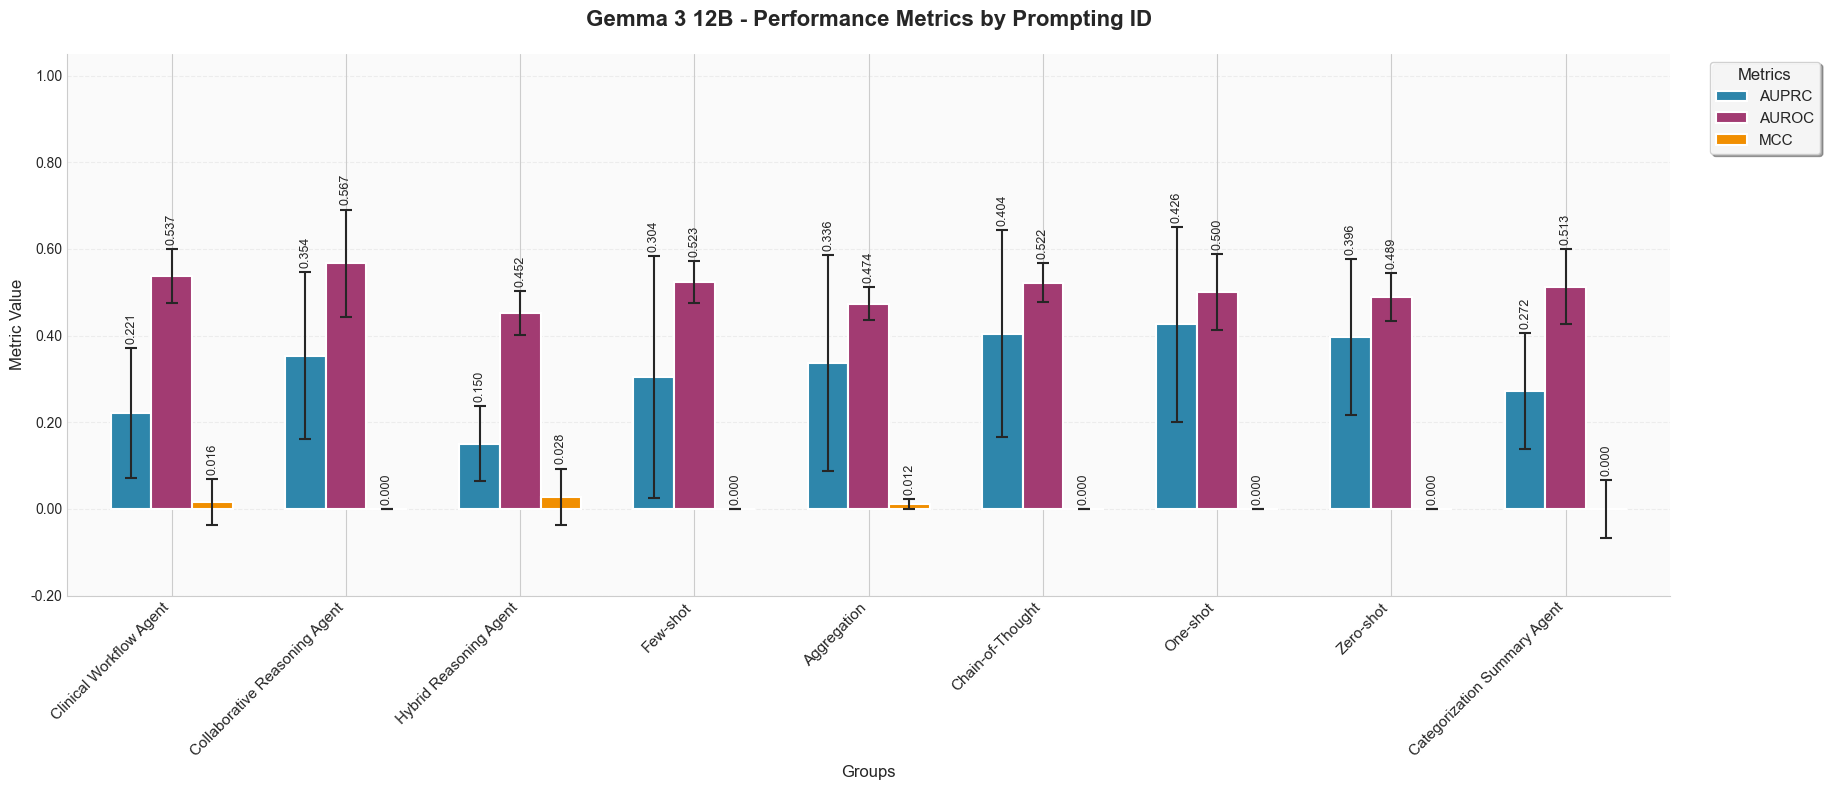

In [7]:
LLMAnalyzer.plot_metrics(
    df_results, group=["prompting_id"], title_prefix="Gemma 3 12B - ",
)

C:\Users\janbe\Documents\GitHub Repos\pulse\src\eval\llm_analyzer.py:953: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df = plot_df.groupby(["Group", "Metric"], as_index=False).agg(


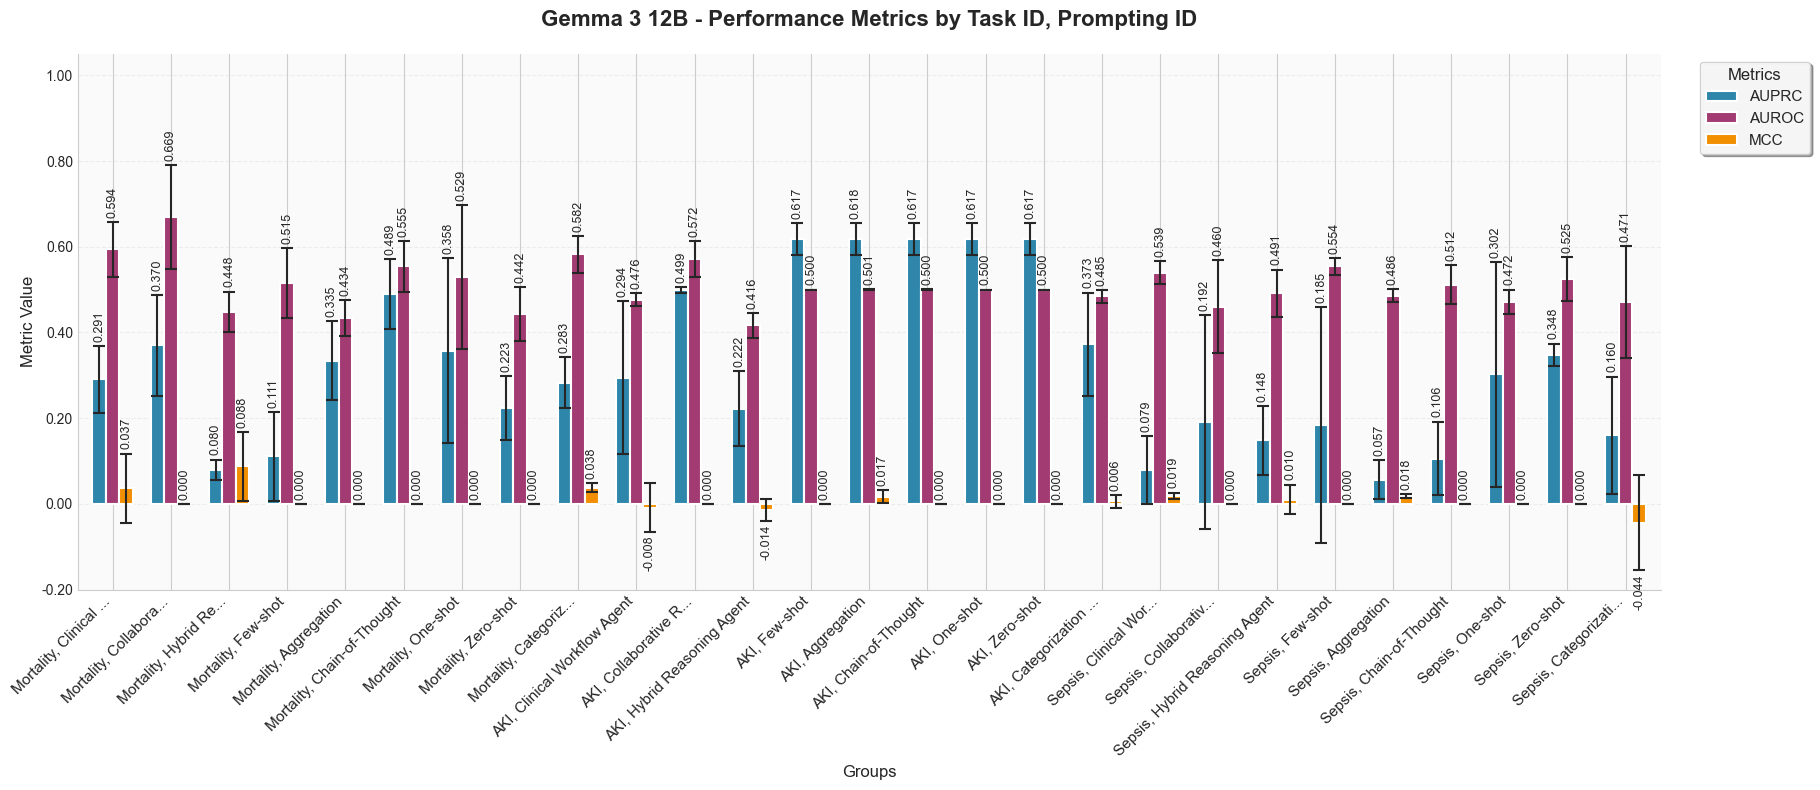

In [8]:
LLMAnalyzer.plot_metrics(
    df_results,
    group=["task_id", "prompting_id"],
    title_prefix="Gemma 3 12B - ",
)